<h1 style="text-align: center;">Simulación y aplicaciones en ciencias sociales y experimentales
</h3>
<h3 style="text-align: center;"> Tema 3. Modelos aleatorios </h3>
<h3 style="text-align: center;"> Modelo de Colas (ejercicios propuestos) </h3>

### Ejercicio 1 

Un servidor con un único procesador ejecuta programas con tiempo CPU siguiendo una distribución exponencial de 3 minutos. Se sigue un protocolo de atención de los programas FIFO. Las llegadas de los programas a la estación sigue un proceso de Poisson de 15 programas cada hora de media. 

1) Calcular el tiempo medio que transcurre desde que se envía un programa al servidor hasta que termina su ejecución. 
2) Calcular el número medio de programas en espera de ejecutarse. 
3) Cacular la probabilidad de que haya más de dos programas en espera de ejecución. 
4) Calcular la probabilidad de que el programa esté en espera más de 10 minutos. 

#### Solución Ejercicio 1

En primer lugar se cargan las librerías y se definen los parámetros del modelo, que son: $\lambda =60/3 = 20$ llegadas de programas de media a la hora y $\mu= 15$ programas de media se ejecutan a la hora. A fin de que las simulaciones de las funciones exponenciales sean representativas, definimos un tiempo de funcionamiento de 240 horas (10 días). 

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.stats as st

# Input Parameters
total_time_h= 240
total_time = 60*total_time_h #en minutos
lamb = 15 ##llegadas cada hora
lamb_inv =60/lamb ##tiempo medio de llegada en minutos
mu = 20 ##servicios cada hora
mu_inv =60/mu ##tiempo medio de servicio en minutos
rho = lamb/mu


Posteriormente simulamos el número de programas que llegan en las 30 horas, los tiempos de llegada y los tiempos de ejecución de cada uno de esos programas, cada uno con su ley de probabilidad conveniente. Medimos el tiempo en segundos para evitar solapamientos en los tiempos de llegada.

In [2]:
# Initialize Parameters
curr_process = None
IAT = []
ST = []
AT = []
wait_time = []
server_busy = False
list_L=[]
list_Lq=[]
list_W=[]
list_Wq=[]
qu=[]
    
num_processes = sum(st.poisson.rvs(lamb,size=total_time_h))
num_processes_served = 0
    
# Populate Inter-Arrival-Times (IAT)
for i in range(num_processes):
    temp = st.expon.rvs(loc=0,scale=lamb_inv)
    if i==0:
        IAT.append(0)
    else:
        IAT.append(int(temp)+1)

# Populate Service-Times (ST) 
for i in range(num_processes):
    temp = st.expon.rvs(loc=0,scale=mu_inv)
    ST.append(int(temp)+1)

# Save a copy of ST
ST_copy = copy.deepcopy(ST)
    
# Get Arrival-Times (AT) from IAT starting at t=0
for i in range(num_processes):
    if i == 0:
        AT.append(0)    
    else:
        AT.append(AT[i-1] + IAT[i])
    wait_time.append(0)


Seguidamente registramos los movimientos de la cola en cada unidad de tiempo, contabilizando la distribución del número de programas en cola y servicio, *list_L*, en cola, *list_Lq*, tiempo de espera en cola y servicio, *list_W*, y en cola, *list_Wq*.

In [3]:
# Simulation of M/M/1 Queue (i represents current time)
for i in range(AT[-1]+ST[-1]):
    for j in range(num_processes):
        if i== AT[j]:
            qu.append(j)

    if not server_busy and bool(qu):
        curr_process = qu[0]
        server_busy = True

    if not server_busy and not bool(qu):
        list_Lq.append(len(qu))
        list_L.append(len(qu))

    if server_busy:
        for item in qu:
            wait_time[item] = wait_time[item] + 1
        list_Lq.append(len(qu)-1)
        list_L.append(len(qu))
        ST[curr_process] = ST[curr_process] - 1
        if ST[curr_process] == 0:
            list_W.append(wait_time[curr_process])
            server_busy = False
            num_processes_served = num_processes_served + 1
            qu.remove(curr_process)
        
list_Wq=np.subtract(list_W,ST_copy[0:len(list_W)])


Finalmente, con las distribuciones de las variables principales, podemos contestar a las cuestiones que nos plantean en el ejercicio: 

In [4]:
print('L exacta: ',lamb/(mu-lamb))
print('L simulada: ', np.mean(list_L))
print('Lq exacta: ',lamb**2/(mu*(mu-lamb)))
print('Lq simulada: ', np.mean(list_Lq))

print('W exacta: ',1/(mu-lamb))
print('W simulada: ', np.mean(list_W)/60)
print('Wq exacta: ',lamb/(mu*(mu-lamb)))
print('Wq simulada: ', np.mean(list_Wq)/60)

#prob lq>2
freq, bins = np.histogram(list_Lq,100)

x = (bins[:-1] + bins[1:]) / 2
prob_dist_Lq= freq/(len(list_Lq))

prob_dist_acum = np.cumsum(prob_dist_Lq)

df=pd.DataFrame({'x': x, 'F(x)': prob_dist_acum})

pLq2=1-df[df['x']>2]['F(x)'].min()

print('La probabilidad de que la cola sea mayor que 2 es: ',pLq2)

#prob Wq>10
freq, bins = np.histogram(list_Wq,100)

x = (bins[:-1] + bins[1:]) / 2
prob_dist_Wq= freq/(len(list_Wq))

prob_dist_acum = np.cumsum(prob_dist_Wq)

df=pd.DataFrame({'x': x, 'F(x)': prob_dist_acum})

pWq10=1-df[df['x']>10]['F(x)'].min()

print('La probabilidad de que el tiempo en cola sea mayor que 10 minutos es: ',pWq10)    


L exacta:  3.0
L simulada:  2.509872313920897
Lq exacta:  2.25
Lq simulada:  1.7454998442852694
W exacta:  0.2
W simulada:  0.1903344671201814
Wq exacta:  0.15
Wq simulada:  0.13236016628873773
La probabilidad de que la cola sea mayor que 2 es:  0.26041731547804414
La probabilidad de que el tiempo en cola sea mayor que 10 minutos es:  0.29109977324263026


Como se puede observar, hay discrepancias entre los valores exactos de la longitud de cola y tiempo de espera con respecto a los simulados. Estas discrepancias se mantienen al simular con horizontes temporales mayores, aunque los valores se mantienen en un entorno de los valores reales. Simulaciones de Montecarlo de este proceso pueden determinar la distribución de estas discrepancias, que tenderán a los valores reales de las medias, según el Teorema Central del Límite. Procedemos a hacer estas simulaciones.  

L exacta:  3.0
L simulada:  2.7137253779041353
Lq exacta:  2.25
Lq simulada:  1.9367866527946607
W exacta:  0.2
W simulada:  0.20488180790399937
Wq exacta:  0.15
Wq simulada:  0.146174141672155


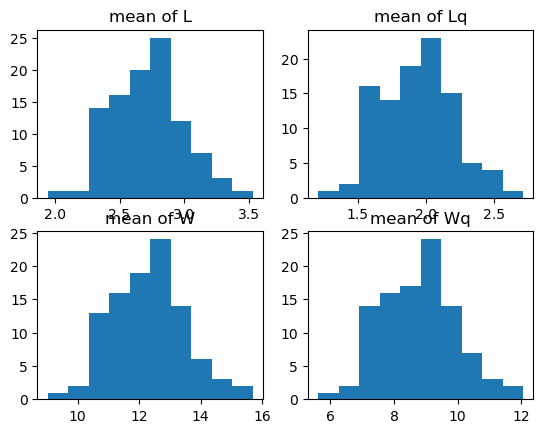

In [5]:
L_mean=[]
Lq_mean=[]
W_mean=[]
Wq_mean=[]
sim=100
for k in range(0,sim):
    # Initialize Parameters
    curr_process = None
    IAT = []
    ST = []
    AT = []
    wait_time = []
    server_busy = False
    list_L=[]
    list_Lq=[]
    list_W=[]
    list_Wq=[]
    qu=[]
        
    num_processes = sum(st.poisson.rvs(lamb,size=total_time_h))
    num_processes_served = 0
        
    # Populate Inter-Arrival-Times (IAT)
    for i in range(num_processes):
        temp = st.expon.rvs(loc=0,scale=lamb_inv)
        if i==0:
            IAT.append(0)
        else:
            IAT.append(int(temp)+1)
    
    # Populate Service-Times (ST) (where ST[i]!=0)
    for i in range(num_processes):
        temp = st.expon.rvs(loc=0,scale=mu_inv)
        ST.append(int(temp)+1)
    
    # Save a copy of ST
    ST_copy = copy.deepcopy(ST)
        
    # Get Arrival-Times (AT) from IAT starting at t=0
    for i in range(num_processes):
        if i == 0:
            AT.append(0)    
        else:
            AT.append(AT[i-1] + IAT[i])
        wait_time.append(0)
        
    # Simulation of M/M/1 Queue (i represents current time)
        
    #for i in range(total_time*conv_t):
    for i in range(AT[-1]+ST[-1]):
        for j in range(num_processes):
            if i== AT[j]:
                qu.append(j)
    
        if not server_busy and bool(qu):
            curr_process = qu[0]
            server_busy = True
    
        if not server_busy and not bool(qu):
            list_Lq.append(len(qu))
            list_L.append(len(qu))
    
        if server_busy:
            for item in qu:
                wait_time[item] = wait_time[item] + 1
            list_Lq.append(len(qu)-1)
            list_L.append(len(qu))
            ST[curr_process] = ST[curr_process] - 1
            if ST[curr_process] == 0:
                list_W.append(wait_time[curr_process])
                #list_Wq.append(wait_time[curr_process])
                server_busy = False
                num_processes_served = num_processes_served + 1
                qu.remove(curr_process)
        
    list_Wq=np.subtract(list_W,ST_copy[0:len(list_W)])
    L_mean.append(np.mean(list_L))
    Lq_mean.append(np.mean(list_Lq))
    W_mean.append(np.mean(list_W))
    Wq_mean.append(np.mean(list_Wq))

fig, axs = plt.subplots(2, 2)
axs[0,0].hist(L_mean)
axs[0,0].set_title("mean of L")
axs[0,1].hist(Lq_mean)
axs[0,1].set_title("mean of Lq")
axs[1,0].hist(W_mean)
axs[1,0].set_title("mean of W")
axs[1,1].hist(Wq_mean)
axs[1,1].set_title("mean of Wq")

from statistics import mean
print('L exacta: ',lamb/(mu-lamb))
print('L simulada: ', mean(L_mean))
print('Lq exacta: ',lamb**2/(mu*(mu-lamb)))
print('Lq simulada: ', mean(Lq_mean))

print('W exacta: ',1/(mu-lamb))
print('W simulada: ', mean(W_mean)/60)
print('Wq exacta: ',lamb/(mu*(mu-lamb)))
print('Wq simulada: ', mean(Wq_mean)/60)



Como se puede observar, la media de la longitud media de la cola se empieza a asemejar a una distribuión normal. Los resultados simulados de los distintos indicadores de la cola son más proximos a los resultados exactos. Por tanto, la media de las probabilidades que nos pide el ejercicio serán también más aproximadas a las reales.  

### Ejercicio 2 (diseño de experimentos)

Otra forma de medir la sensibilidad de un modelo aleatorio a variaciones de los parámetros es por medio del **diseño de experimentos**. Estos consisten en asumir escenarios o **niveles** de los parámetros o **factores** del modelo y observar el efecto combinado de estos cambios sobre una variable objetivo, también denominada **respuesta**. 

Así, en el ejercicio 1, asúmanse dos niveles de llegada media de programas al servidor, estos son 13 y 17 programas por hora. Asúmanse también dos niveles de tiempo medio de servicio, 18 y 22 por hora. Como respuesta elegimos la probabilidad de que el tiempo de cola sea mayor que 10 minutos. O sea, buscamos encontrar el efecto de cambios de los factores en la probabilidad de que el tiempo de cola sea mayor que 10 minutos. 

#### Solución Ejercicio 2

Dado que tenemos tan solo dos factores, elegimos el **diseño factorial $2^k$**, siendo $k$ el número de factores. Consiste en realizar las simulaciones indicadas en la siguiente tabla: 

| Combinación | Factor 1 ($\lambda$) | Factor 2 ($\mu$) | Respuesta |
| --- | --- | --- |--- |
| 1 | - | - | $R_1$ |
| 2 | + | - | $R_2$ |
| 3 | - | + | $R_3$ |
| 4 | + | + | $R_4$ |

Entonces, el efecto medio del factor $j$ ($j=1,2$), es el cambio medio de la respuesta al pasar del signo $-$ al signo $+$, esto es: 

$$e_1 = {(R_2-R_1)+(R_4-R_3) \over 2},$$

$$e_2 = {(R_3-R_1)+(R_4-R_2) \over 2}.$$

Y el efecto de interacción $1 \times 2$, esto es, el efecto de un factor cuando se producen cambios en el otro factor, se calcula como: 

$$e_{12} = {1 \over 2} \left({(R_4-R_3) \over 1} - {(R_2-R_1) \over 1}\right),$$


## Referencias

- Cao Abad, R. (2002). Introducción a la simulación y a la teoría de colas. A Coruña: Netbiblo.
- Law, A.M. (2007). Simulation Modeling and Analysis. New York: McGraw Hill
